In [ ]:
#主模型

In [188]:
import pandas as pd
from fredapi import Fred
import numpy as np 
from matplotlib import pyplot as plt 
from matplotlib.pyplot import figure
import bt# step 1: build Investment Clock Class
from tiingo import TiingoClient
%matplotlib inline

In [189]:
def AssetPoolFixed():
    return {
      "Reflection": ['IYF','IYH','IYK','IYC'],
      "Recovery": ['IYZ','IYW','IYM','IYC'],
      "Overheat": ['IYJ','IYW','IYM','IYE'],
      "Stagflation": ['IDU','IYH','IYK','IYE']
    }

In [296]:
def assetWeight():
    return {
      "Reflection": {"IYF":0.2067,
                    "IYH": 0.2637,
                     "IYK":0.2947,
                     "IYC":0.2347    
      },
      "Recovery": {'IYZ':0.2693,
                   'IYW':0.235,
                   'IYM':0.2240,
                   'IYC':0.2709,
      },
      "Overheat": {
          'IYJ':0.2933,
          'IYW':0.2794,
          'IYM':0.2166,
          'IYE':0.2105
      },
      "Stagflation": {
          'IDU':0.2879,
          'IYH':0.2593,
          'IYK':0.2849,
          'IYE':0.1677
      }
    }
# def assetWeight():
#     return {
#       "IYF": 0.33,
#       "IYW": 0.45
# #       "Overheat": [0.25,0.25,0.1,0.4],
# #       "Stagflation": [0.25,0.25,0.25,0.25]
#     }

In [297]:
fred = Fred(api_key="f47911535ed5029402710ad27afa0d23")
signals = pd.DataFrame(dict(
    GDP = fred.get_series('GDPC1'),# Real GDP
    CPI = fred.get_series('CPILFESL'), # Core CPI
  )
).fillna(method='ffill').pct_change(12).dropna()*100

print(signals)
print("average of GDP")
print(signals['GDP'].mean())
print('average of CPI')
print(signals['CPI'].mean())

                 GDP       CPI
1958-01-01 -2.871428  2.807018
1958-02-01 -2.871428  2.797203
1958-03-01 -2.871428  2.787456
1958-04-01 -2.018409  2.430556
1958-05-01 -2.018409  2.430556
...              ...       ...
2021-11-01  5.533484  4.952634
2021-12-01  5.533484  5.476621
2022-01-01  3.939172  6.040783
2022-02-01  3.939172  6.415744
2022-03-01  3.939172  6.436039

[771 rows x 2 columns]
average of GDP
2.9989820997900467
average of CPI
3.634204942461929


In [298]:
def InvestmentClockFixed(x,cuts={'GDP':2.9,'CPI':3}):
   
    x_ = x.copy().assign(Growth=None,Inflation=None,Theme=None)

    # define high and low growth
    x_.loc[x['GDP']<=cuts["GDP"],'Growth'] = 'low'
    x_.loc[x['GDP']>cuts['GDP'],'Growth'] = 'high'

    # define high and low inflation  
    x_.loc[x['CPI']<=cuts['CPI'],'Inflation'] = 'low'
    x_.loc[x['CPI']>cuts['CPI'],'Inflation'] = 'high'

    # define investment clock phases
    x_.loc[(x_.Growth=='low')&(x_.Inflation=='low'),'Theme'] = 'Reflection'
    x_.loc[(x_.Growth=='high')&(x_.Inflation=='low'),'Theme'] = 'Recovery'
    x_.loc[(x_.Growth=='high')&(x_.Inflation=='high'),'Theme'] = 'Overheat'
    x_.loc[(x_.Growth=='low')&(x_.Inflation=='high'),'Theme'] = 'Stagflation'
    
    return x_.dropna()

                 GDP       CPI Growth Inflation        Theme
1958-01-01 -2.871428  2.807018    low      high  Stagflation
1958-02-01 -2.871428  2.797203    low      high  Stagflation
1958-03-01 -2.871428  2.787456    low      high  Stagflation
1958-04-01 -2.018409  2.430556    low      high  Stagflation
1958-05-01 -2.018409  2.430556    low      high  Stagflation
1958-06-01 -2.018409  2.422145    low      high  Stagflation
1958-07-01 -0.724798  2.068966    low      high  Stagflation
1958-08-01 -0.724798  2.068966    low      high  Stagflation
1958-09-01 -0.724798  2.061856    low      high  Stagflation
1958-10-01  2.658137  1.712329   high       low     Recovery


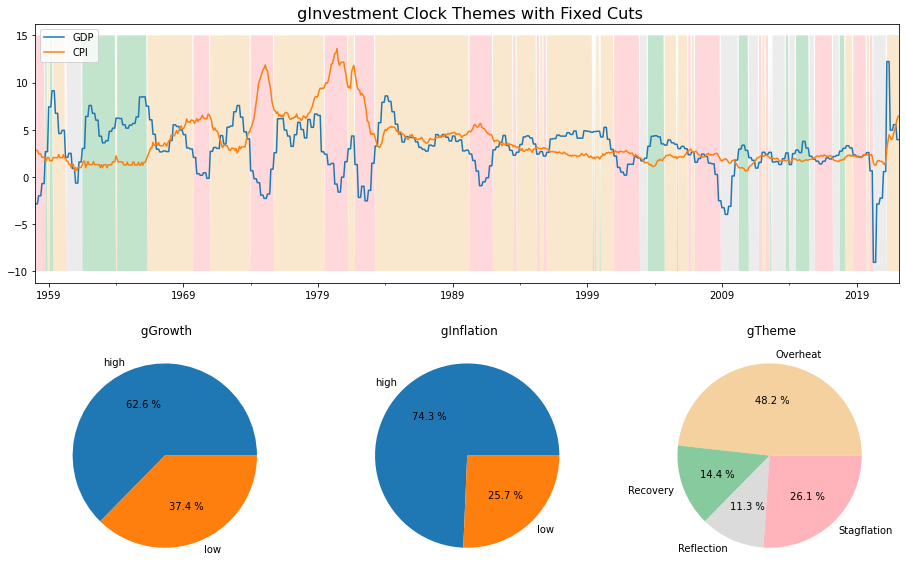

In [299]:
themes = InvestmentClockFixed(signals,cuts={'GDP':2.5,'CPI':2})
print(themes.head(10))
themes.to_csv('GDP_CPI.csv')
fig = plt.figure(figsize=(12,8))
fig.suptitle(' gInvestment Clock Themes with Fixed Cuts',fontsize=16)
ax1 = fig.add_axes((0,0.5,1,0.45))
ax2 = fig.add_axes((0,0,0.3,0.4))
ax3 = fig.add_axes((0.35,0,0.3,0.4))
ax4 = fig.add_axes((0.7,0,0.3,0.4))
y_lim = (-10,15)
colors = dict(
  Overheat='#f4d19e',
  Recovery='#87ca9d',
  Reflection='#dbdbdb',
  Stagflation='#ffb3ba'
) 
p1 = themes[['GDP','CPI']].plot(ax=ax1)
for t in ['Overheat','Recovery','Reflection','Stagflation']:
       ax1.fill_between(
      themes.index, y_lim[0],y_lim[1], 
      where=(themes.Theme==t),
      interpolate = True,
      facecolor=colors[t], 
      alpha = 0.5
   )
growth_counts=themes.Growth.value_counts()
ax2.pie(growth_counts,autopct='%.1f %%',
        labels=growth_counts.index)
ax2.set_title(' gGrowth')
inflation_counts=themes.Inflation.value_counts()
ax3.pie(inflation_counts,autopct='%.1f %%',
        labels=inflation_counts.index)
ax3.set_title(' gInflation')
theme_counts=themes.Theme.value_counts().sort_index(ascending=True)
ax4.pie(theme_counts,autopct='%.1f %%',
        labels=theme_counts.index,colors=colors.values())
ax4.set_title(' gTheme')
plt.show()

In [310]:
data = pd.read_csv('ishareETF_data_2002.csv')
data =data.set_index('Unnamed: 0')
data.index.name = 'Date'
data.index = pd.to_datetime(data.index).strftime('%Y/%m/%d')
#data.index = pd.to_datetime(data.index)
#data['DateM'] = pd.DatetimeIndex(data.index).to_period('M')
print(data)

#data = data.drop(['IYZ','IYW','IYM','IYJ','IYW','IYM','IYE','IDU','IYR'], axis=1) #Reflection ['IYF','IYH','IYK','IYC']
#data = data.drop(['IYJ','IYE','IDU','IYR','IYH','IYR','IDU','IYK','IYF'], axis=1) #Recovery
#data = data.drop(['IDU','IYH','IYR','IDU','IYK','IYF','IYZ','IYC','IDU'], axis=1) #Overheat
#data = data.drop(['IYR','IDU','IYF','IYZ','IYC','IDU','IYC','IYJ','IYW'], axis=1) #Stagflation
data = data.drop(['IYR'], axis=1)
data.index = pd.to_datetime(data.index).strftime('%Y/%m/%d')
data.index = pd.to_datetime(data.index)
print(data.head(10))


                  IYC        IDU        IYZ         IYW         IYJ  \
Date                                                                  
2002/07/29   9.431615  12.545165   9.084387    7.225539   15.355110   
2002/07/30   9.421006  13.465497   9.302223    7.280129   15.504374   
2002/07/31   9.308548  13.587501   9.626035    7.140379   15.481410   
2002/08/01   9.039073  13.314319   9.390536    6.791002   15.175227   
2002/08/02   8.699578  13.088877   9.337548    6.581376   14.658542   
...               ...        ...        ...         ...         ...   
2021/08/13  78.324174  83.151732  33.432473  104.633771  113.373877   
2021/08/16  78.395450  83.661448  33.334142  104.763503  113.731523   
2021/08/17  77.317334  83.701821  33.176813  103.675751  112.638715   
2021/08/18  77.117960  83.230316  32.793322  102.458267  111.575711   
2021/08/19  77.098022  83.475891  33.098148  103.276575  111.009437   

                   IYH        IYF        IYE         IYK         IYM  \
Date

In [311]:
import bt# step 1: build Investment Clock Class
class InvestmentClock(bt.Algo):   
    def __init__(self, themes,lag = pd.DateOffset(days=0),pool = AssetPoolFixed(),weights = assetWeight()):
        super(InvestmentClock, self).__init__()
        self.Themes = themes
        self.lag = lag
        self.pool = pool
        print(self.Themes)
        self.weights = weights
    def __call__(self, target):
        t0 = target.now - self.lag
#         print('target')
#         print(target.head())
        Theme = self.Themes[:t0][-1]
#         print(Theme)
#         print(1)
        #print(weights)
        target.temp['selected'] = self.pool[Theme] #对应周期，target目标列（目标标的）
        print(self.pool[Theme])
        target.temp['weights'] = self.weights[Theme].copy()
        print(self.weights[Theme])

        return True# step 2: build Investment Clock backtest
def bt_InvestmentClock(name,tickers,prices,signals,cuts={'GDP':2.5,'CPI':2}):

    themes = InvestmentClockFixed(signals,cuts)
#     print('themes:')
#     print(themes)
    asset_pool = AssetPoolFixed()
    asset_wpool = assetWeight()
#     print("asset_pool:")
#     print(asset_pool)
#     print(1)
    
    
#     ws = pd.DataFrame()
#     ws = data
#     ws[:] = 0.5
#     print(ws)

    s = bt.Strategy(name,algos = [bt.algos.RunQuarterly(),bt.algos.SelectAll(),bt.algos.SelectThese(tickers),
          InvestmentClock(themes.Theme,
             lag=pd.DateOffset(days=0),
             pool = asset_pool,weights = asset_wpool),
                                  
          bt.algos.Rebalance()
        ],
       )
#     print('themes.Theme')
#     print(themes.Theme)
#bt.algos.WeighTarget(ws),
    return bt.Backtest(s, prices)

4799
1958-01-01    Stagflation
1958-02-01    Stagflation
1958-03-01    Stagflation
1958-04-01    Stagflation
1958-05-01    Stagflation
                 ...     
2021-11-01       Overheat
2021-12-01       Overheat
2022-01-01       Overheat
2022-02-01       Overheat
2022-03-01       Overheat
Name: Theme, Length: 771, dtype: object
['IDU', 'IYH', 'IYK', 'IYE']
{'IDU': 0.2879, 'IYH': 0.2593, 'IYK': 0.2849, 'IYE': 0.1677}
['IDU', 'IYH', 'IYK', 'IYE']
{'IDU': 0.2879, 'IYH': 0.2593, 'IYK': 0.2849, 'IYE': 0.1677}
['IYF', 'IYH', 'IYK', 'IYC']
{'IYF': 0.2067, 'IYH': 0.2637, 'IYK': 0.2947, 'IYC': 0.2347}
['IYF', 'IYH', 'IYK', 'IYC']
{'IYF': 0.2067, 'IYH': 0.2637, 'IYK': 0.2947, 'IYC': 0.2347}
['IYZ', 'IYW', 'IYM', 'IYC']
{'IYZ': 0.2693, 'IYW': 0.235, 'IYM': 0.224, 'IYC': 0.2709}
['IYZ', 'IYW', 'IYM', 'IYC']
{'IYZ': 0.2693, 'IYW': 0.235, 'IYM': 0.224, 'IYC': 0.2709}
['IYZ', 'IYW', 'IYM', 'IYC']
{'IYZ': 0.2693, 'IYW': 0.235, 'IYM': 0.224, 'IYC': 0.2709}
['IYZ', 'IYW', 'IYM', 'IYC']
{'IYZ': 0.2693, 

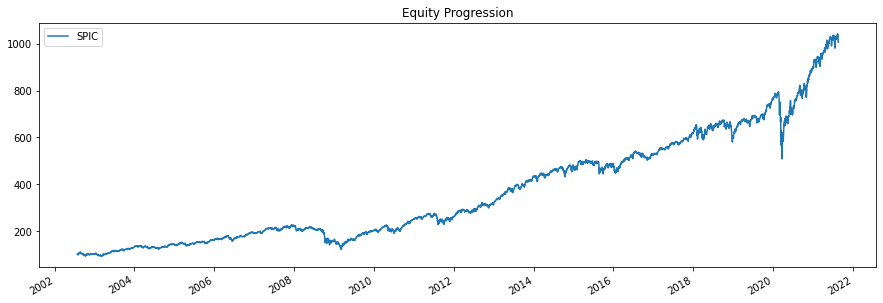

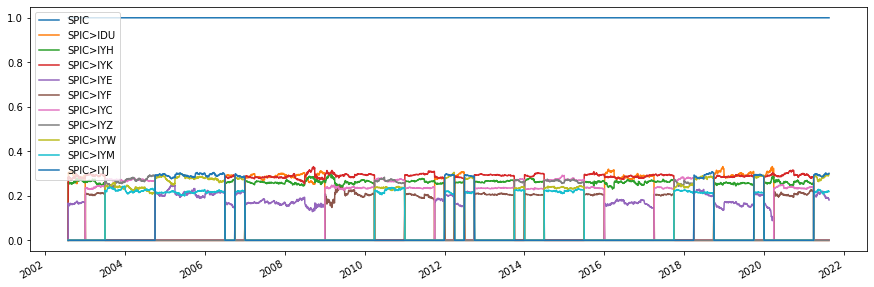

In [312]:
tickers = ['IYC','IDU','IYZ','IYW','IYJ','IYH','IYF','IYE','IYK','IYM']
prices = data.dropna()
print(len(prices))
backtest_spic = bt_InvestmentClock('SPIC',tickers,prices,signals,cuts={'GDP':2.5,'CPI':2})
report = bt.run(backtest_spic)
# create a backtest and run it
report.plot()
report.display()
report.plot_weights()

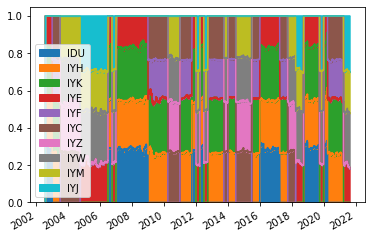

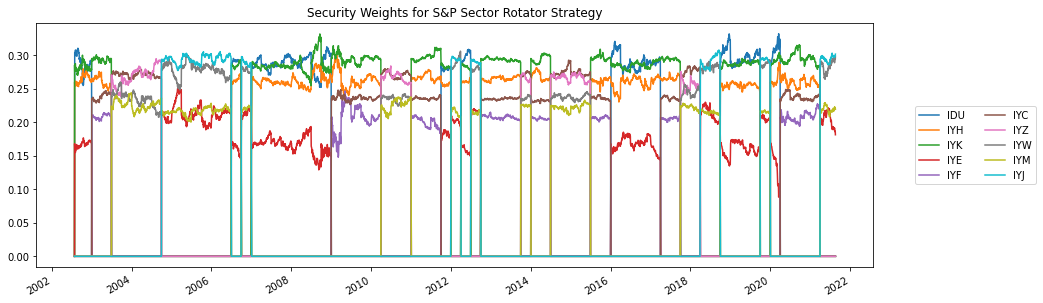

In [303]:
# Plot Sector Weights
report.backtests['SPIC'].security_weights.plot.area()
report.plot_security_weights(0)
plt.title("Security Weights for S&P Sector Rotator Strategy")
plt.legend(ncol=2,loc='right',bbox_to_anchor=(1.2,0.5))
plt.show()

                 IDU       IYH       IYK       IYE  IYF  IYC  IYZ       IYW  \
2002-07-28  0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.000000   
2002-07-29  0.287899  0.259266  0.284884  0.167699  0.0  0.0  0.0  0.000000   
2002-07-30  0.303775  0.257327  0.275494  0.163155  0.0  0.0  0.0  0.000000   
2002-07-31  0.300961  0.259115  0.275667  0.164014  0.0  0.0  0.0  0.000000   
2002-08-01  0.302878  0.257592  0.281605  0.157674  0.0  0.0  0.0  0.000000   
...              ...       ...       ...       ...  ...  ...  ...       ...   
2021-06-03  0.000000  0.000000  0.000000  0.218045  0.0  0.0  0.0  0.268110   
2021-06-04  0.000000  0.000000  0.000000  0.217468  0.0  0.0  0.0  0.271066   
2021-06-07  0.000000  0.000000  0.000000  0.217849  0.0  0.0  0.0  0.273234   
2021-06-08  0.000000  0.000000  0.000000  0.218966  0.0  0.0  0.0  0.272287   
2021-06-09  0.000000  0.000000  0.000000  0.218776  0.0  0.0  0.0  0.273840   

                 IYM       IYJ  
2002-07-28  0.0000

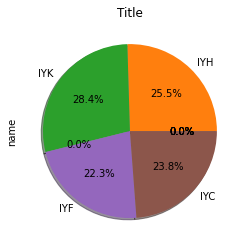

In [304]:
reportData = report.backtests['SPIC'].security_weights
reportData.to_csv('reportData.csv')
print(reportData.head(-50))
plotData = reportData.iloc[[-100]].T
plotData.columns = ['name']
plot = plotData.plot.pie(y='name', title="Title", legend=False, \
                   autopct='%1.1f%%',  \
                   shadow=True, startangle=0)

IDU       IYH       IYK       IYE       IYF       IYC       IYZ  IYW       IYM       IYJ     
0.000000  0.266342  0.293306  0.000000  0.207723  0.232379  0.0  0.000000  0.000000  0.000000    2
          0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.000000  0.000000    1
          0.271456  0.289146  0.000000  0.200897  0.238303  0.0  0.000000  0.000000  0.000000    1
          0.271727  0.291768  0.000000  0.203964  0.232321  0.0  0.000000  0.000000  0.000000    1
          0.271688  0.296601  0.000000  0.194121  0.237370  0.0  0.000000  0.000000  0.000000    1
                                                                                                ..
          0.000000  0.000000  0.216067  0.000000  0.000000  0.0  0.280984  0.214253  0.288484    1
                              0.216015  0.000000  0.000000  0.0  0.282021  0.212617  0.289118    1
                              0.215973  0.000000  0.000000  0.0  0.274003  0.222293  0.287535    1
               

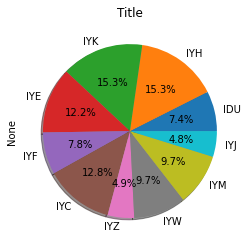

In [305]:
reportData.value_counts()
print(reportData.value_counts())
reportData.mask(reportData > 0, 1, inplace=True)
print(reportData)
print(reportData.sum(axis=0)/len(reportData))

drawData = reportData.sum(axis=0)/len(reportData)
plot =drawData.plot.pie(y='name', title="Title", legend=False, \
                   autopct='%1.1f%%',  \
                   shadow=True, startangle=0)